In [1]:
"""
a script to download, filter, preprocess, and partition the raw data into training and test splits
"""



'\na script to download, filter, preprocess, and partition the raw data into training and test splits\n'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk
import json
import os
import scipy
from pathlib import Path
from PIL import Image
import matplotlib.patches as patches

In [3]:
def read_image(ct_path, only_img=False):
    """Reads NIFTI image and returns it as a 3D numpy array"""
    if os.path.exists(ct_path):
        itkimage = sitk.ReadImage(ct_path)
        ct_scan = sitk.GetArrayFromImage(itkimage)
        if only_img:
            return ct_scan
        origin = np.array(list(reversed(itkimage.GetOrigin())))
        spacing = np.array(list(reversed(itkimage.GetSpacing())))
        direction = np.array(list(reversed(itkimage.GetDirection())))
        return ct_scan, spacing
    else:
        print("The file path doesn't exist")


In [4]:
ct_path = r"C:\Users\sanatbyeka\Desktop\calcium_scoring\data\raw\bifurcation_point\1\TRV1P1CTI.nii"
ct_scan, spacing = read_image(ct_path)
print(ct_scan.shape)
print(spacing)

(64, 512, 512)
[2.5        0.48828101 0.48828101]


In [5]:
def plot_scan(ct_scan, n=5, window=500, level=100):
    #visualizing the first n*n images of the given patient data
    fig, ax = plt.subplots(n, n, figsize=(10, 10))
    assert n*n < ct_scan.shape[0], "n out of range. Please enter smaller number"
    for i in range(n*n):
        row = i // n
        col = i % n
        vmin = level - window/2
        vmax = level + window/2
        ax[row,col].imshow(ct_scan[i, :, :], cmap=plt.cm.gray, vmin=vmin, vmax=vmax)
        ax[row,col].axis('off')
    fig.suptitle(f"First {n*n} slices of a given CT scan")
    plt.show()

# plot_scan(ct_scan)

In [6]:
#get 3D bounding box coordinates from json file
def read_from_json(json_path, orientation=False):
    if os.path.exists(json_path):
        with open(label_path) as f:
            label_json = json.load(f)
            x, y, z = label_json['markups'][0]['center']
            width, height, length = label_json['markups'][0]['size']
            center, dimension = [x,y,z], [width, height, length]
            if orientation:
                orientation = np.array(label_json['markups'][0]['orientation'])
                return center, dimension, orientation
            return center, dimension
    else:
        print(f"The file '{json_path}' does not exist.")

label_path = r'C:\Users\sanatbyeka\Desktop\calcium_scoring\data\raw\bifurcation_point\1\bifurcation.json'
center, dimension, orientation = read_from_json(label_path, orientation=True)
print("x,y,z center: ", center)
print("width, height, length: ", dimension)
print("orientation: \n", orientation.reshape(3,3))

x,y,z center:  [145.5313262939453, 153.39918518066406, 126.98651123046875]
width, height, length:  [8.274045854420109, 8.986473428814236, 14.496468986526537]
orientation: 
 [[-1. -0. -0.]
 [-0. -1. -0.]
 [ 0.  0.  1.]]


In [7]:
def get_3Dbox_coordinates(json_path, spacing):
    center, dimension = read_from_json(json_path)
    x = center[0] / spacing[1]
    y = center[1] / spacing[2]
    z = center[2] / spacing[0]
    center = [x, y, z]
    w = dimension[0] / spacing[1]
    h = dimension[1] / spacing[2]
    l = dimension[2] / spacing[0]
    dimension = [w,h,l]
    return center, dimension
center_scaled, dimension_scaled = get_3Dbox_coordinates(label_path, spacing=spacing)
print(center_scaled, dimension_scaled)

[298.04830178139736, 314.1616846492601, 50.7946044921875] [16.94525418390228, 18.40430656868937, 5.7985875946106145]


x_min, y_min:  (289.5756746894462, 304.95953136491545)


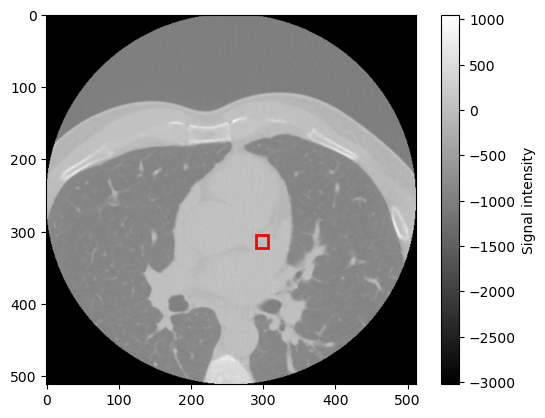

x,y :  [298.04830178139736, 314.1616846492601, 50.7946044921875]
w,h :  [16.94525418390228, 18.40430656868937]


In [20]:
def plot_single_slice_box(slice, center, size, title=""):
  """
  Plots n-th slice of a scan
  Center is a list containing center_x, center_y
  Size is a list containing width, height
  """
  plt.imshow(slice, cmap=plt.cm.gray)
  if title != "":
    plt.title(title)
  w, h = size
  box = plt.Rectangle((center[0]-w/2, center[1]-h/2), w, h, fill=False, edgecolor='red', linewidth=2)
  print("x_min, y_min: ", (center[0]-w/2, center[1]-h/2)) 
  plt.gca().add_patch(box)
  plt.colorbar(label='Signal intensity')
  plt.show()

plot_single_slice_box(ct_scan[52,:,:], center=center_scaled, size=dimension_scaled[:2])
print("x,y : ", center_scaled)
print("w,h : ", dimension_scaled[:2])

In [21]:
def get_slice_idxs_with_bbox(z, l, spacing_z):
    """ returns the index of slices with bounding box"""
    l = l / spacing_z
    idxs = [int(idx) for idx in range(int(z - l), int(z + l) + 1)]
    return idxs
get_slice_idxs_with_bbox(center_scaled[2], dimension_scaled[2], spacing[0])

[48, 49, 50, 51, 52, 53]

In [22]:
def normaliza_relative_to_image(center_2D, size_2D, im_shape):
    """ Normalize 2D x, y center coordinates and width, height relative to the image size"""
    im_w, im_h = im_shape
    center_x = center_2D[0] / im_w
    center_y = center_2D[1] / im_h
    width = size_2D[0] / im_w
    height = size_2D[1] / im_h
    labels = [center_x, center_y, width, height]
    return labels

print(normaliza_relative_to_image(center_scaled[:2], dimension_scaled[:2], ct_scan[0].shape))

[0.5821255894167917, 0.6135970403305862, 0.03309619957793414, 0.03594591126697143]


In [23]:
def clip_values(ct_scan, min_bound=-1000, max_bound=1000):
    """
    Clips outliers, if not specified min_bound=-1000 max_bound=1000
    """
    img = ct_scan
    img = np.clip(img, min_bound, max_bound).astype(np.float32)
    return img

In [24]:
def bbox3d_to_yolo(root_folder, patient, destination_folder):
    """Converts 3D slices and 3D box coordinates to each 2D slices with 2D boxes and saves as png & txt"""
    destination_folder = Path(destination_folder)
    ct_path, bbox_path = "", ""
    for filename in os.listdir(root_folder + "\\" + patient):
        current_file_path = os.path.join(root_folder + "\\" + patient, filename)
        if filename.endswith(".nii"):
            ct_path = current_file_path
        elif filename.endswith(".json"): 
            bbox_path = current_file_path

    if os.path.exists(ct_path) and os.path.exists(bbox_path):
        ct_im, spacing = read_image(ct_path)
        #ct_im = clip_values(ct_im)
        [x,y,z], [w,h,l] = get_3Dbox_coordinates(bbox_path, spacing)
        idxes = get_slice_idxs_with_bbox(z, l, spacing[0])
        for idx in range(ct_im.shape[0]):
            #write 3d images into 2d slice
            slice_data = ct_im[idx, :, :]
            slice_data = (slice_data - slice_data.min()) / (slice_data.max() - slice_data.min()) * 255
            slice_data = slice_data.astype('uint8')
            # Convert the 2D slice to a PIL Image
            slice_image = Image.fromarray(slice_data)
            image_path = destination_folder / 'images' / f'{patient}_{str(idx)}.png'
            image_path.parent.mkdir(parents=True, exist_ok=True)
            slice_image.save(image_path)

            #write label files if there is a bounding box in the slice
            if idx in idxes:
                labels = normaliza_relative_to_image([x,y], [w,h], slice_data.shape)
                label_line = '1 ' + ' '.join(map(str, labels))
                label_path = destination_folder / 'labels' / f'{patient}_{str(idx)}.txt'
                label_path.parent.mkdir(parents=True, exist_ok=True)
                with label_path.open('w') as f:
                    f.write(label_line)
    else: 
        print(f'Path doesnt exist: {ct_path} or {bbox_path}')

       

root_folder_path = r"C:\Users\sanatbyeka\Desktop\calcium_scoring\data\raw\bifurcation_point"
destination_folder = r"C:\Users\sanatbyeka\Desktop\calcium_scoring\data\processed\bifurcation_point"
bbox3d_to_yolo(root_folder_path, '1', destination_folder)

In [ ]:
def process_bifurcation_data(root_folder, destination_folder):


['C:\\Users\\sanatbyeka\\Desktop\\calcium_scoring\\data\\processed\\bifurcation_point\\images\\1_48.png', 'C:\\Users\\sanatbyeka\\Desktop\\calcium_scoring\\data\\processed\\bifurcation_point\\images\\1_49.png', 'C:\\Users\\sanatbyeka\\Desktop\\calcium_scoring\\data\\processed\\bifurcation_point\\images\\1_50.png', 'C:\\Users\\sanatbyeka\\Desktop\\calcium_scoring\\data\\processed\\bifurcation_point\\images\\1_51.png', 'C:\\Users\\sanatbyeka\\Desktop\\calcium_scoring\\data\\processed\\bifurcation_point\\images\\1_52.png', 'C:\\Users\\sanatbyeka\\Desktop\\calcium_scoring\\data\\processed\\bifurcation_point\\images\\1_53.png']
['C:\\Users\\sanatbyeka\\Desktop\\calcium_scoring\\data\\processed\\bifurcation_point\\labels\\1_48.txt', 'C:\\Users\\sanatbyeka\\Desktop\\calcium_scoring\\data\\processed\\bifurcation_point\\labels\\1_49.txt', 'C:\\Users\\sanatbyeka\\Desktop\\calcium_scoring\\data\\processed\\bifurcation_point\\labels\\1_50.txt', 'C:\\Users\\sanatbyeka\\Desktop\\calcium_scoring\\dat

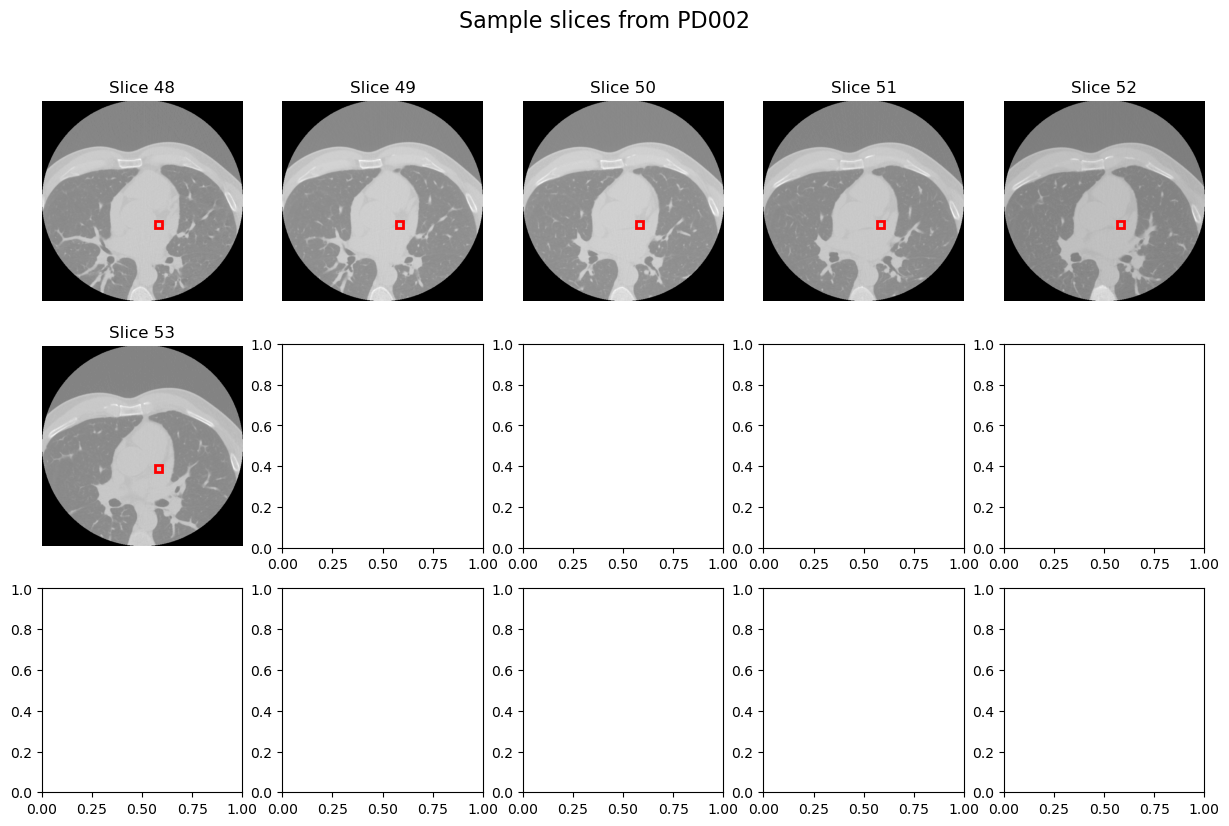

In [15]:
def plot_imgs_boxes(images_folder, labels_folder, title="", columns=5, rows=3):
  # filter images with labels for plotting
  image_files, label_files = [], []
  for label_file in os.listdir(labels_folder):
    label_files.append(os.path.join(labels_folder, label_file))
    for image_file in os.listdir(images_folder):
      if image_file.split('.')[0] == label_file.split('.')[0]:
        image_files.append(os.path.join(images_folder, image_file))
  image_files, label_files = sorted(image_files), sorted(label_files)
  print(image_files)
  print(label_files)
  #plot
  fig, axes = plt.subplots(rows, columns, figsize=(columns*3, rows*3))
  fig.suptitle(title, fontsize=16)
  for i, (image_file, label_file) in enumerate(zip(image_files, label_files)):
    if i < columns * rows:
      with open(label_file, 'r') as f:
          labels_data = f.readlines()
      ax = axes.flat[i]
      label = labels_data[0].strip().split()
      class_id, x_center, y_center, w, h = map(float, label)
      # Read and display the image
      img = Image.open(image_file)
      ax.imshow(img, cmap='gray')
      im_w, im_h = img.size 
      # Draw bounding box
      w = w * im_w
      h = h * im_h
      x = x_center * im_w - w/2
      y = y_center * im_h - h/2
      rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
      slice_idx = (image_file.split('_')[-1]).split('.')[0]
      ax.set_title("Slice " + slice_idx)
      ax.add_patch(rect)
      ax.axis('off')

images_folder = r"C:\Users\sanatbyeka\Desktop\calcium_scoring\data\processed\bifurcation_point\images"
labels_folder = r"C:\Users\sanatbyeka\Desktop\calcium_scoring\data\processed\bifurcation_point\labels"
plot_imgs_boxes(images_folder, labels_folder, title="Sample slices from PD002")

## Preprocess Aorta

In [25]:
def get_index_segment_slice(mask):
    """Get index of the slices that contain segmentation"""
    segment_idx = []
    for i in range(mask.shape[0]):
        if sum(mask[i].ravel() > 0): #if there is a segmentation mask in slice i
            segment_idx.append(i)
    if not segment_idx:
        raise ValueError("There is no segmentation mask")
    else:
        return segment_idx

In [26]:
def calculate_bbox_from_slice(mask_slice):
    """Accepts single 2D slice of a mask 
    returns normalized center_x, center_y, w, h relative to the image"""
    non_zero_pixels = np.argwhere(mask_slice == 1)
    if len(non_zero_pixels) == 0:
        return None 
    min_row, min_col = np.min(non_zero_pixels, axis=0)
    max_row, max_col = np.max(non_zero_pixels, axis=0)
    im_w, im_h = mask_slice.shape[0], mask_slice.shape[1]
    center_x = ((min_col + max_col) / 2) / im_w
    center_y = ((min_row + max_row) / 2) / im_h
    width = (max_col - min_col) / im_w
    height = (max_row - min_row) / im_h
    labels = [center_x, center_y, width, height]
    return labels

In [27]:
def fix_direction(image_path):
    """This function will flip the image axis back to [1,1,1] """
    itk_image = sitk.ReadImage(image_path)
    direction_matrix = np.array(itk_image.GetDirection()).reshape((3, 3))
    flip_axes = [i for i, val in enumerate(np.diag(direction_matrix)) if val < 0]
    
    if flip_axes:
        direction_matrix[flip_axes, :] = -direction_matrix[flip_axes, :]
        itk_image.SetDirection(direction_matrix.flatten())
        
        data_array = sitk.GetArrayFromImage(itk_image)
        data_array = np.flip(data_array, axis=flip_axes)
        itk_image = sitk.GetImageFromArray(data_array)
        itk_image.SetDirection(direction_matrix.flatten())
    
    arr_im = sitk.GetArrayFromImage(itk_image)
    return arr_im

In [28]:

def mask3d_to_bbox_yolo(root_folder, patient, destination_folder):
    """Function to convert 3D segmentation mask to 2D bounding box for each slice then save
    patient_data_path containing CT scan and segmented aorta mask (both NIFTI files)
    """
    destination_folder = Path(destination_folder)
    mask_path = os.path.join(root_folder + "\\" + patient, 'aorta_mask.nii')
    ct_path = os.path.join(root_folder + "\\" + patient, 'og_ct.nii')
    if os.path.exists(mask_path) and os.path.exists(ct_path):
        ct_im, mask = fix_direction(ct_path), fix_direction(mask_path)
        slices_idx_with_segment = get_index_segment_slice(mask)
        for idx in range(ct_im.shape[0]):
            #write 3d images into 2d slice
            slice_data = ct_im[idx, :, :]
            slice_data = (slice_data - slice_data.min()) / (slice_data.max() - slice_data.min()) * 255
            slice_data = slice_data.astype('uint8')
            # Convert the 2D slice to a PIL Image
            slice_image = Image.fromarray(slice_data)
            image_path = destination_folder / 'images' / f'{patient}_{str(idx)}.png'
            image_path.parent.mkdir(parents=True, exist_ok=True)
            slice_image.save(image_path)
            #write label files if there is a segmentation in the slice
            if idx in slices_idx_with_segment:
                label_line = '0 ' + ' '.join(map(str, calculate_bbox_from_slice(mask[idx])))
                label_path = destination_folder / 'labels' / f'{patient}_{str(idx)}.txt'
                label_path.parent.mkdir(parents=True, exist_ok=True)
                with label_path.open('w') as f:
                    f.write(label_line)
    else: 
        print(f'Path doesnt exist: {mask_path}')

       

root_folder_path = r"C:\Users\sanatbyeka\Desktop\calcium_scoring\data\raw\aorta"
destination_folder = r"C:\Users\sanatbyeka\Desktop\calcium_scoring\data\processed\aorta"
mask3d_to_bbox_yolo(root_folder_path, 'PD002', destination_folder)

In [20]:
def process_aorta_data(aorta_folder_path, destination_folder):
    """ Accepts a folder containing patients data folders. each of which has CT image and mask """
    for patient_folder in os.listdir(aorta_folder_path):
        # mask3d_to_bbox_yolo(aorta_folder_path, patient_folder)
        mask3d_to_bbox_yolo(aorta_folder_path, patient_folder, destination_folder)


['C:\\Users\\sanatbyeka\\Desktop\\calcium_scoring\\data\\processed\\aorta\\images\\PD002_26.png', 'C:\\Users\\sanatbyeka\\Desktop\\calcium_scoring\\data\\processed\\aorta\\images\\PD002_27.png', 'C:\\Users\\sanatbyeka\\Desktop\\calcium_scoring\\data\\processed\\aorta\\images\\PD002_28.png', 'C:\\Users\\sanatbyeka\\Desktop\\calcium_scoring\\data\\processed\\aorta\\images\\PD002_29.png', 'C:\\Users\\sanatbyeka\\Desktop\\calcium_scoring\\data\\processed\\aorta\\images\\PD002_30.png', 'C:\\Users\\sanatbyeka\\Desktop\\calcium_scoring\\data\\processed\\aorta\\images\\PD002_31.png', 'C:\\Users\\sanatbyeka\\Desktop\\calcium_scoring\\data\\processed\\aorta\\images\\PD002_32.png', 'C:\\Users\\sanatbyeka\\Desktop\\calcium_scoring\\data\\processed\\aorta\\images\\PD002_33.png', 'C:\\Users\\sanatbyeka\\Desktop\\calcium_scoring\\data\\processed\\aorta\\images\\PD002_34.png', 'C:\\Users\\sanatbyeka\\Desktop\\calcium_scoring\\data\\processed\\aorta\\images\\PD002_35.png', 'C:\\Users\\sanatbyeka\\Deskt

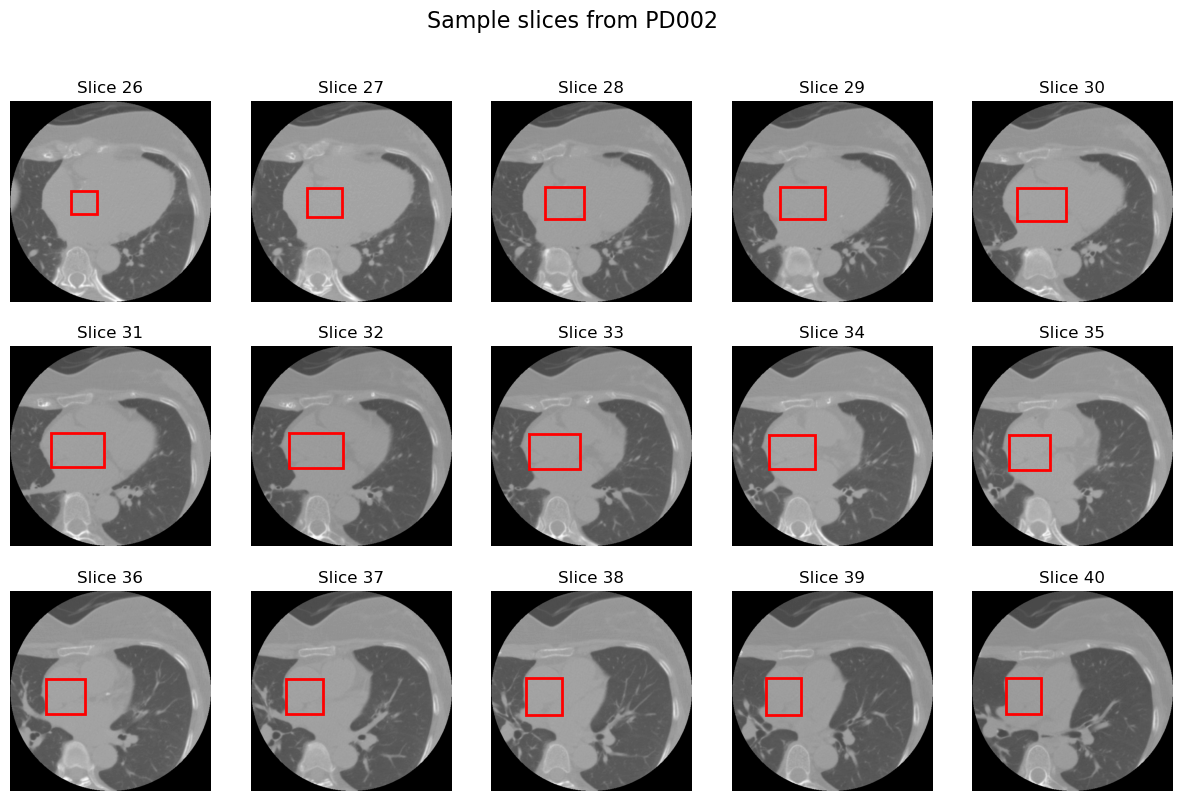

In [21]:
images_folder = r"C:\Users\sanatbyeka\Desktop\calcium_scoring\data\processed\aorta\images"
labels_folder = r"C:\Users\sanatbyeka\Desktop\calcium_scoring\data\processed\aorta\labels"
plot_imgs_boxes(images_folder, labels_folder, title="Sample slices from PD002")

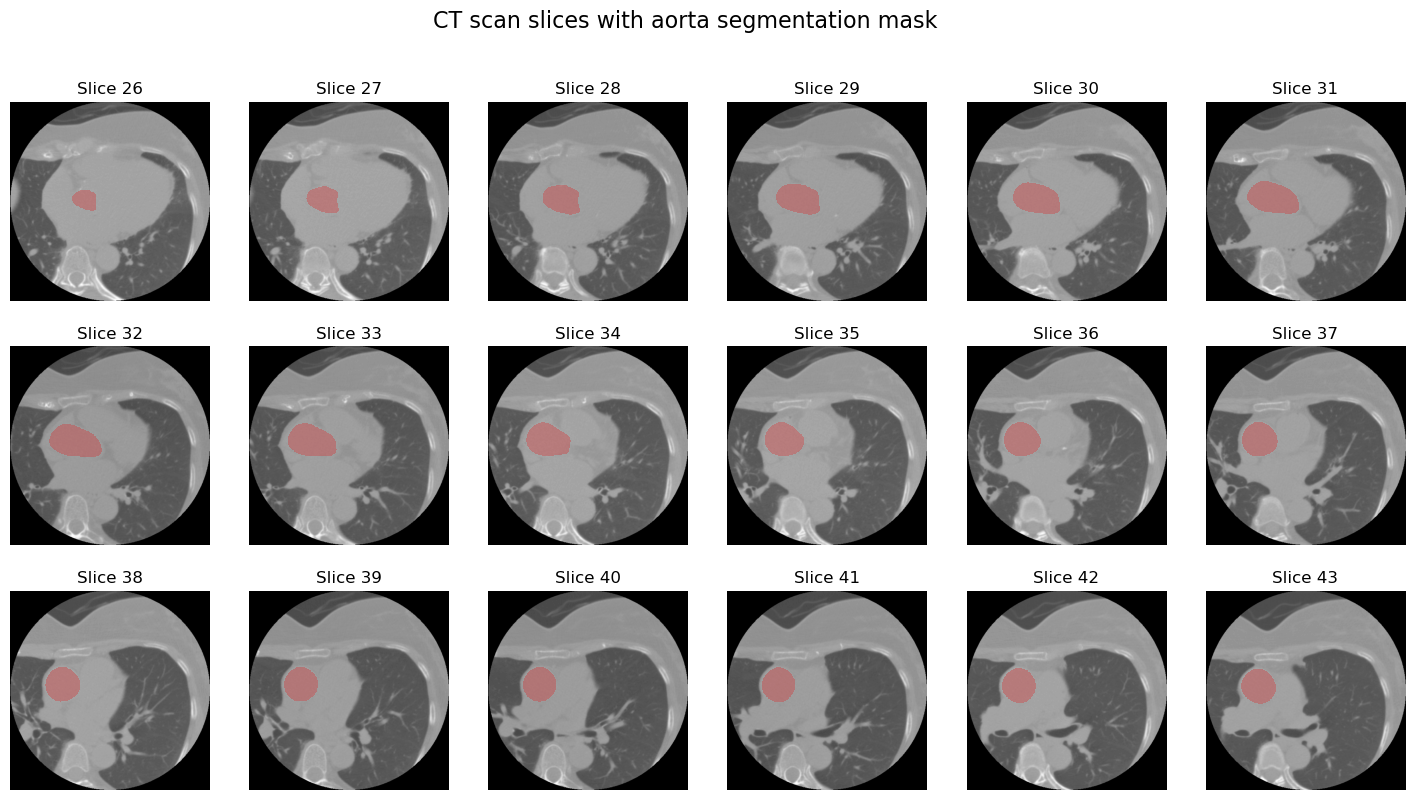

In [52]:
from matplotlib.colors import ListedColormap

def plot_masks(ct_scan, mask, row=3, col=6):
    """Function to plot overlaying masks on top of the slices of the given CT scan image"""
    fig, axes = plt.subplots(row, col, figsize=(col*3, row*3))
    fig.suptitle("CT scan slices with aorta segmentation mask", fontsize=16)
    idxs = get_index_segment_slice(mask)
    for i in range(len(idxs)):
        if i < col * row:
            ax = axes.flat[i]
            ax.imshow(ct_scan[idxs[i]], cmap='gray')
            seg = np.ma.masked_where(mask[idxs[i]] == False, mask[idxs[i]])
            reduced_transparency_cmap = ListedColormap([(r, g, b, 0.3) for r, g, b in plt.get_cmap('Set1').colors])
            ax.imshow(seg, cmap=reduced_transparency_cmap)
            ax.set_title("Slice " + str(idxs[i]))
            ax.axis('off')
    plt.show()
    
ct_im = fix_direction(r'C:\Users\sanatbyeka\Desktop\calcium_scoring\data\raw\aorta\PD002\og_ct.nii')
aorta_mask = fix_direction(r'C:\Users\sanatbyeka\Desktop\calcium_scoring\data\raw\aorta\PD002\aorta_mask.nii')
plot_masks(ct_im, aorta_mask)

## Data Augmentation Functions

In [1]:
def clip_values(ct_scan, min_bound=-1000, max_bound=1000):
    """
    Clips outliers, if not specified min_bound=-1000 max_bound=1000
    """
    img = ct_scan
    img = np.clip(img, min_bound, max_bound).astype(np.float32)
    return img

In [32]:
def resample(ct_scan, spacing, out_spacing=[1.0,1.0,1.0], label_path=None):
    """ Resample images to 1mm spacing, if otherwise specify out_spacing value """
    resize_factor = spacing / out_spacing
    new_shape = ct_scan.shape * resize_factor
    real_resize_factor = new_shape / ct_scan.shape
    new_spacing = spacing / real_resize_factor
    resampled_scan = scipy.ndimage.zoom(ct_scan, real_resize_factor, mode='nearest')
    if label_path is not None:
        resampled_coordinates, resampled_dim = get_3Dbox_coordinates(label_path, new_spacing, scaling_factor=real_resize_factor)
        return resampled_scan, resampled_coordinates, resampled_dim
    return resampled_scan

resampled_scan, resampled_coordinates, resampled_dim = resample(ct_scan, spacing, label_path=label_path)
#plot_bbox(resampled_scan, resampled_coordinates, resampled_dim)
print("Resampled bounding box coordinates: ", resampled_coordinates)
print("Resampled bounding box dimensions: ", resampled_dim)
print("Resampled scan shape: ", resampled_scan.shape)
#plot_single_slice(resampled_scan)


Resampled bounding box coordinates:  [146.74349975585938, 135.17697143554688, 99.39756774902344]
Resampled bounding box dimensions:  [18.64875334  3.5870903   4.41794767]
Resampled scan shape:  (140, 250, 250)


In [33]:
def random_flip(ct_scan, label_path=None, spacing=None):
    """Returns a random flipped 3d array"""
    axes = [0, 1, 2]
    rand = np.random.randint(0, 3)
    print(rand)
    img = np.flip(ct_scan, axis=axes[rand])
    img = np.squeeze(img)
    
    if label_path is not None:
        center, [l,w,h] = get_3Dbox_coordinates(label_path, spacing)
        return img, np.flip(np.array(center).reshape(3,1,-1), axis=axes[rand])
    return img

flipped_scan, flipped_center = random_flip(ct_scan, label_path=label_path, spacing=spacing)
#plot_bbox(ct_scan, center_coordinates, dimension)
print(flipped_center)
#plot_bbox(flipped_scan, flipped_center.reshape(3,), dimension)

2
[[[300.53083424]]

 [[276.84257268]]

 [[ 39.7590271 ]]]


In [139]:

    
def augment_scan(image_path, label_path=None, resample=True, normalize=False, 
                clip_values=False, random_flip=False, random_rotate3D=False):
    